In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import warnings

import helpers as hlp
import helpers.features as feat
import helpers.dataset.PlantVillage as pv
import helpers.split as split
import helpers.visual_words as vw

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# enlever FutureWarning de sklearn 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")


#
# train/test sets
# 
train, test = split.load(configs.split)
print("Train size", len(train))
print("Test size", len(test))


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)

Train size 3711
Test size 928
Dataset (60343, 4)


In [4]:
#
# features sift
#

configs.sift.force_generate = True
configs.sift.read_only = False

if "sift_features" in locals():
    del sift_features

with hlp.Profile() as sift_loading:
    #
    # obtenir les sift features pour chaque image du dataset
    #
    sift_iter = feat.DatasetIter(pv_dataset, 
                                 pv_dataframe.loc[train + test, "image_path"].items(),
                                 len(train + test))
    sift_features = feat.load(configs.sift, sift_iter)

print(f"SIFT loading:", sift_loading.round_duration(), "s")
print("SIFT keypoints", sift_features.key_points.shape)
print("SIFT features", sift_features.features.shape)

if configs.sift.force_generate or sift_features.train_features is None:
    feat.update_train_test(sift_features, train, test)

print("SIFT train features", sift_features.train_features.shape)
print("SIFT test features", sift_features.test_features.shape)

Extraire features


  0%|          | 0/4639 [00:00<?, ?it/s]

SIFT loading: 35.85 s
SIFT keypoints (1460929, 7)
SIFT features (1460929, 128)
SIFT train features (1169216, 128)
SIFT test features (291713, 128)



In [5]:
#
# bovw sift
#

configs.sift_bovw.force_generate = True

if "sift_bovw" in locals():
    del sift_bovw

# soyez patient, ce n'est pas interactif
with hlp.Profile() as sift_bovw_profile:
    sift_bovw = vw.load_bovw(configs.sift_bovw, sift_features.train_features)

print("SIFT BoVW loading:", sift_bovw_profile.round_duration(), "s")
print("SIFT BoVW clusters:", sift_bovw.cluster_centers.shape)

Construction Bag of Visual Words
SIFT BoVW loading: 12.25 s
SIFT BoVW clusters: (500, 80)


In [6]:
#
# dataset vw sift
#

configs.sift_dataset_vw.force_generate = True

if "sift_pv_vw" in locals():
    del sift_pv_vw

with hlp.Profile() as sift_pv_vw_loading:
    sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw,
                                   sift_features,
                                   configs.sift_bovw,
                                   sift_bovw,
                                   train,
                                   test)
    
print(f"SIFT PlantVillage Visual Word loading:", sift_pv_vw_loading.round_duration(), "s")
print("SIFT PlantVillage Visual Words", sift_pv_vw.vw_freqs.shape)

Construction Visual Words


  0%|          | 0/4639 [00:00<?, ?it/s]

SIFT PlantVillage Visual Word loading: 12.66 s
SIFT PlantVillage Visual Words (4639, 500)


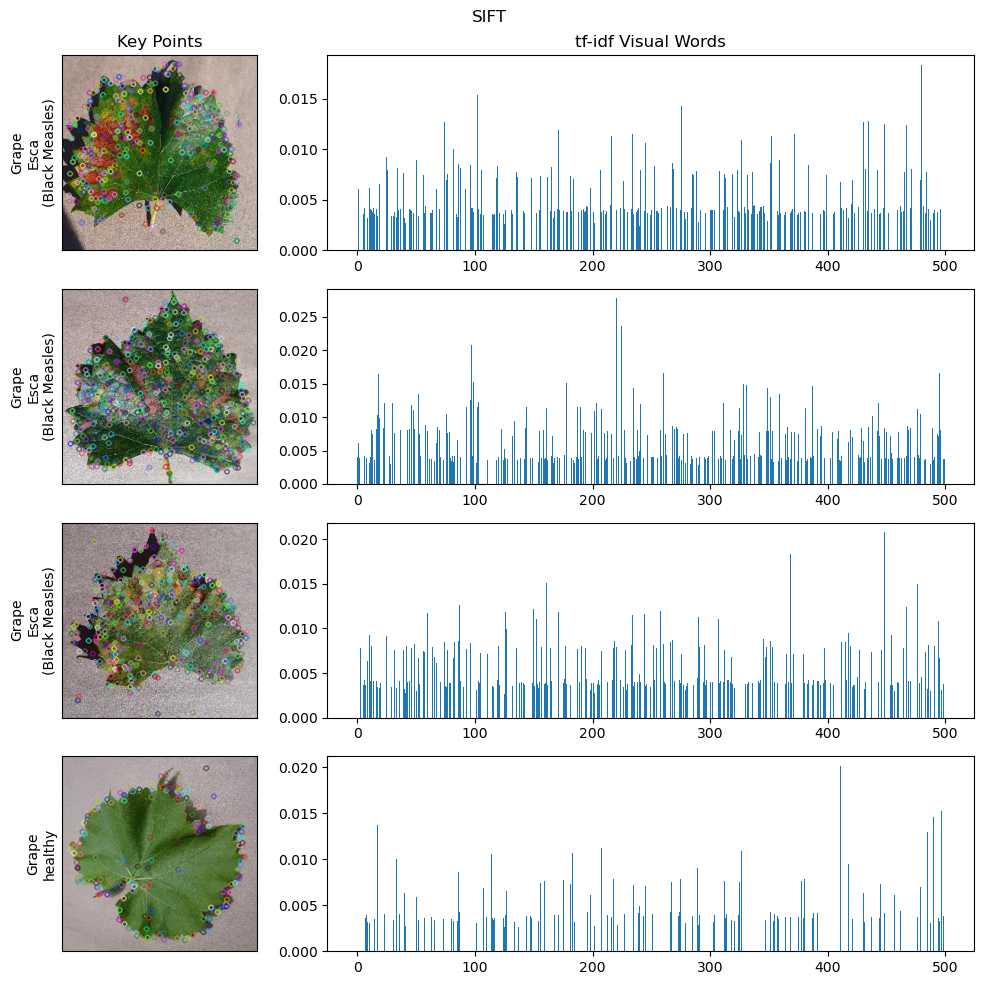

In [7]:
#
# visualiser quelques visual words sift
#

SAMPLES_GRID = (4, 2)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def affiche_image(image_indices, visual_words, idf, features, pv_vw):
    x_range = range(visual_words.n_clusters)
    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE,
                                width_ratios=[1, 3])

    for i, image_index in enumerate(image_indices):
        key_points = features.index_to_key_points[str(image_index)][...]
        visual_words_freq = pv_vw.index_to_vw_freqs[str(image_index)][...].flatten()
        tf_idf = np.multiply(idf, visual_words_freq)

        image = pv_dataset.get_image(image_index)
        image_key_points = visual_words.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[i, 0])
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points)

        plt.sca(axes[i, 1])
        plt.bar(x_range, tf_idf)

    axes[0, 0].set_title("Key Points")
    axes[0, 1].set_title("tf-idf Visual Words")
    

# selectionner quelques images aleatoirement
random.seed(33)
image_indices = random.choices(train, k=SAMPLES_COUNT)
image_indices.sort()

affiche_image(image_indices,
              vw.VisualWords(configs.sift, sift_bovw),
              np.ravel(sift_bovw.idf),
              sift_features, 
              sift_pv_vw)

plt.suptitle("SIFT")
plt.tight_layout()
plt.show() 

In [8]:
def load_knn(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5
        
        pipe = Pipeline([("scaler", StandardScaler()),
                         ("knn", KNeighborsClassifier())])

        pipe_parameters = {"knn__n_neighbors": range(1, 5)}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_knn(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "KNN n_neighbors:", pipe.named_steps["knn"].n_neighbors)
    print(method_name, "KNN test score:", accuracy_score(test_y, test_y_hat).round(4))
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - KNN - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()


#
# mettre le data dans une forme acceptable pour sklearn
#
train_y = pv_dataframe.loc[train, "label"]
test_y = pv_dataframe.loc[test, "label"]

# *_pv_vw garantissent l'ordre donne par train/test lors de l'etape precedante 
# alors faire gaffe a ne pas le changer
sift_train_x = np.multiply(sift_pv_vw.train_vw_freqs[...], sift_bovw.idf)
sift_test_x = np.multiply(sift_pv_vw.test_vw_freqs[...], sift_bovw.idf)

assert sift_train_x.shape[0] == train_y.shape[0]
assert sift_test_x.shape[0] == test_y.shape[0]

print("SIFT PlantVillage train Visual Words", sift_train_x.shape)
print("SIFT PlantVillage test Visual Words", sift_train_x.shape)

SIFT PlantVillage train Visual Words (3711, 500)
SIFT PlantVillage test Visual Words (3711, 500)


In [9]:
def load_rf(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5

        pipe = Pipeline([("scaler", StandardScaler()),
                         ("forest_gump", RandomForestClassifier())])

        pipe_parameters = {"forest_gump__n_estimators": range(100, 200)}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS,
                                  n_jobs=-1)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_rf(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "Random Forest n_estimators:", pipe.named_steps["forest_gump"].n_estimators)
    print(method_name, "Random Forest test score:", accuracy_score(test_y, test_y_hat).round(4))
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - Random Forest - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()
    

Search time: 2.31 s
Best params {'knn__n_neighbors': 2}
Train score: 0.571

SIFT KNN n_neighbors: 2
SIFT KNN test score: 0.5776
Effectifs test set:
Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


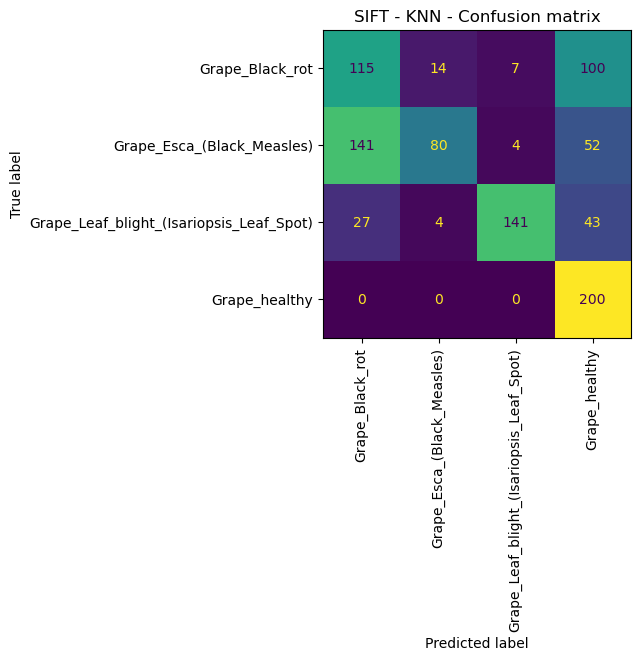

In [10]:
#
# SIFT KNN
#
sift_knn_pipe = load_knn("models/sift_knn.pkl", sift_train_x, train_y)
analysis_knn("SIFT", sift_knn_pipe, sift_test_x, test_y)

Search time: 145.91 s
Best params {'forest_gump__n_estimators': 192}
Train score: 0.8332

SIFT Random Forest n_estimators: 192
SIFT Random Forest test score: 0.8254
Effectifs test set:
Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


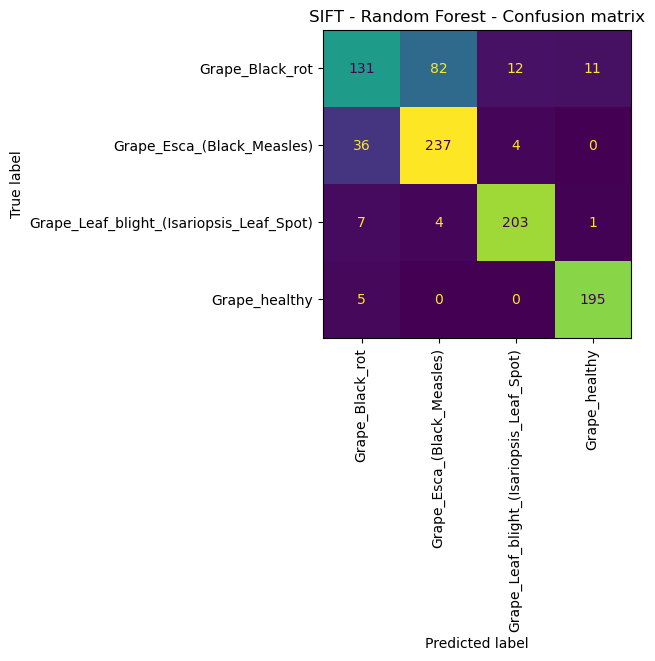

In [11]:
#
# SIFT Random Forest
#
sift_rf_pipe = load_rf("models/sift_random_forest.pkl", sift_train_x, train_y)
analysis_rf("SIFT", sift_rf_pipe, sift_test_x, test_y)